### Trying Causal Flows

A causal flow is a flow called with a Adjecency matrix like
```
zuko.flows.BPF(features=3,  transforms=1, context=context, adjacency=A, ...)
```

In [15]:
import numpy as np
import torch
import zuko
import matplotlib.pyplot as plt
import time

In [18]:
n_train = 20000

In [19]:
## Running in colab to install zuko
#### Old Version !pip install git+https://github.com/oduerr/zuko.git@bernstein
#!pip install git+https://github.com/probabilists/zuko.git@bernstein

### Import and Data Generation


In [33]:
import torch
import numpy as np

# Function to scale data tensors
def scale_df(dat_tf):
    dat_min = torch.min(dat_tf, dim=0)[0]  # Getting the minimum
    dat_max = torch.max(dat_tf, dim=0)[0]  # Getting the maximum
    dat_scaled = (dat_tf - dat_min) / (dat_max - dat_min)  # Scaling
    return dat_scaled

# Data Generating Process (DGP)
def dgp(n_obs):
    print("=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)")
    flip = torch.randint(0, 2, (n_obs,))  # Randomly generating 0s and 1s
    X_1 = flip * torch.normal(-2, torch.sqrt(torch.tensor(1.5)), size=(n_obs,)) \
          + (1 - flip) * torch.normal(1.5, 1, size=(n_obs,))
    X_2 = -X_1 + torch.normal(0, 1, size=(n_obs,))
    X_3 = X_1 + 0.25 * X_2 + torch.normal(0, 1, size=(n_obs,))
    dat_s = torch.stack([X_1, X_2, X_3], dim=1)  # Stacking the columns to form the data tensor
    dat_tf = dat_s.float()  # Ensuring the tensor is of type float
    scaled = scale_df(dat_tf) * 0.99 + 0.005  # Scaling the data
    A = torch.tensor([[0, 1, 1], [0, 0, 1], [0, 0, 0]], dtype=torch.float32, requires_grad=True)  # Defining the matrix A
    return {'df_orig': dat_tf, 'df_scaled': scaled, 'A': A}

train = dgp(n_train)
X_matrix = train['df_scaled']

print(X_matrix.shape)  
#5 number summary for each column
print("Min:", X_matrix.numpy()[:,2].min())
print("Max:", X_matrix.numpy()[:,2].max())
print("25th percentile:", np.percentile(X_matrix.numpy()[:,2], 25))
print("Median:", np.percentile(X_matrix.numpy()[:,2], 50))
print("75th percentile:", np.percentile(X_matrix.numpy()[:,2], 75))

=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
torch.Size([20000, 3])
Min: 0.005
Max: 0.995
25th percentile: 0.42398619651794434
Median: 0.5331347584724426
75th percentile: 0.6392455995082855


In [22]:
# Create the tensor
A = train['A'].T
print(A)
y = X_matrix
x = torch.ones((y.shape[0],1))
#x = torch.ones([1000,1])  # does not work w/o context (also for NSF) using dummy variable
flow =  zuko.flows.BPF(features=3,  transforms=1, hidden_features=[30]*5, degree=10, adjacency=A, linear=True, bound=y.abs().max()*1.1)
print("Untrained Causal Flow ", -flow().log_prob(y).mean()) 


#flow =  zuko.flows.BPF(features=3,  context=1, transforms=1, hidden_features=[30]*5, degree=10, linear=True, bound=y.abs().max()*1.1)
#-flow(x).log_prob(y).mean() #Gives Inf for linear=False in case of 11.0997

flow =  zuko.flows.BPF(features=3,  transforms=1, hidden_features=[30]*5, degree=10, linear=True, bound=y.abs().max()*1.1)
-flow().log_prob(y).mean() 
print("Untrained  Flow ", -flow().log_prob(y).mean()) 

tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.]], grad_fn=<PermuteBackward0>)
Untrained Causal Flow  tensor(2.1511, grad_fn=<NegBackward0>)
Untrained  Flow  tensor(1.6834, grad_fn=<NegBackward0>)


### Training and plotting of loss curves

In [25]:

context = 0
flows = {
    "BPF_causal": zuko.flows.BPF(features=3,  transforms=1, context=context, adjacency=A, hidden_features=[20]*5, degree=10, linear=False, bound=y.abs().max()*1.1),
    "BPF": zuko.flows.BPF(features=3, context=context, transforms=1, hidden_features=[20]*5, degree=10, linear=False, bound=y.abs().max()*1.1),  
    "NSF": zuko.flows.NSF(features=3, context=context, transforms=1, hidden_features=[20]*5, bound=y.abs().max()*1.1),  
}

In [26]:
epochs = 1000
losses_train = []
losses_test = []
training_times = []
import time, tqdm

print("Number of training data points: ", y.shape[0])
# Add a tqdm progress bar for the outer loop
for name in flows.keys():
    flow = flows[name]
    optimizer = torch.optim.AdamW(flow.parameters(), lr=0.001)
    loss_history = np.zeros(epochs)
    loss_history_test = np.zeros(epochs)
    start_time = time.time()
    
    # Add a tqdm progress bar for the inner loop
    for e in range(epochs):
        y_test = dgp(1000)['df_scaled']  # Test data on more points
       
        # Adding a regularization term of A to the loss
        # if (context > 0):
        #     loss = -flow(x).log_prob(y).mean()  #+ 0.1 * torch.norm(A, p=1) # -log p(y | x)
        #     NLL_test = -flow(x_test).log_prob(y_test).mean() 
        #else:
        loss = -flow().log_prob(y).mean()
        NLL_test = -flow().log_prob(y_test).mean() 
        
        loss_history_test[e] = (NLL_test.detach().numpy())
        loss_history[e] = (loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
        # Manually update A
        # with torch.no_grad():
        #     A -= 1e-4 * A.grad
        #     A.grad = None  # Clear gradients of A after updating
    
    training_times.append(time.time() - start_time)  # Training time
    losses_train.append(loss_history)
    losses_test.append(loss_history_test)

Number of training data points:  20000
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the VACA1 paper in the linear Fashion (Tables 5/6)
=== Using the DGP of the 

In [27]:
A

tensor([[0., 0., 0.],
        [1., 0., 0.],
        [1., 1., 0.]], grad_fn=<PermuteBackward0>)

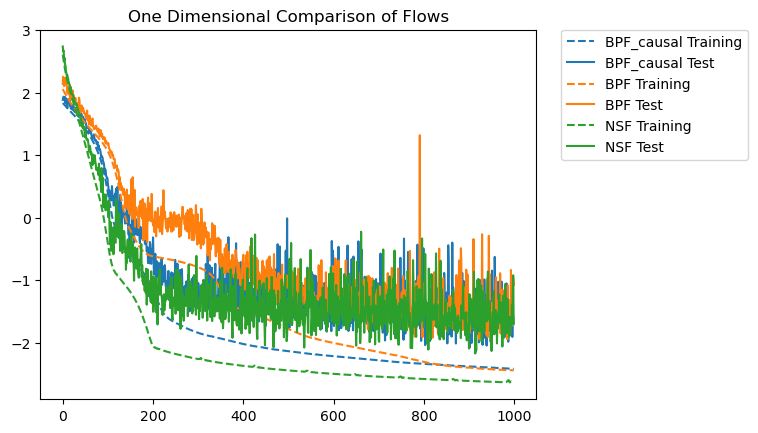

**Timeings done on a MAC M2**

,Flow,Training Time,Avg Training Loss (Last 15),Avg Test Loss (Last 15)
0,BPF_causal,26.235627,-2.417524,-1.633014
2,NSF,33.701686,-2.624907,-1.554362
1,BPF,26.352286,-2.442835,-1.433760


In [28]:
import pandas as pd

# Plot loss
plt.figure()
colors = plt.cm.tab10(np.arange(len(flows)))
for i, name in enumerate(flows.keys()):
    flow = flows[name]
    loss_train = losses_train[i]
    loss_test = losses_test[i]
    plt.plot(loss_train, label=f"{name} Training", color=colors[i], linestyle='--')
    plt.plot(loss_test, label=f"{name} Test", color=colors[i], linestyle='-')
#Place the legend outside the figure/plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("One Dimensional Comparison of Flows")
plt.show()

# Calculate average losses for the last 15 epochs
avg_train_loss_last_15 = [np.mean(loss[-15:]) for loss in losses_train]
avg_test_loss_last_15 = [np.mean(loss[-15:]) for loss in losses_test]

# Create DataFrame with flow names, training times, and average losses
df = pd.DataFrame({
    "Flow": [name for name in flows.keys()],
    "Training Time": training_times,
    "Avg Training Loss (Last 15)": avg_train_loss_last_15,
    "Avg Test Loss (Last 15)": avg_test_loss_last_15
})

# Display DataFrame
df
df_sorted = df.sort_values(by="Avg Test Loss (Last 15)")
from IPython.display import display, Markdown
display(Markdown("**Timeings done on a MAC M2**"))
display(df_sorted)

# TODO SAMPLING NOT YET IMPLEMENTED

In [29]:
flow = flows['BPF']
flow().sample((4,))
#xx = torch.linspace(-1, 1, 10)
#flow().log_prob(xx[...,None]).exp().detach().numpy()

tensor([[0.8832, 0.1531, 0.7156],
        [0.5486, 0.4016, 0.4610],
        [0.2454, 0.7939, 0.1253],
        [0.2513, 0.5252, 0.3627]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_11954/1173259666.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is cal

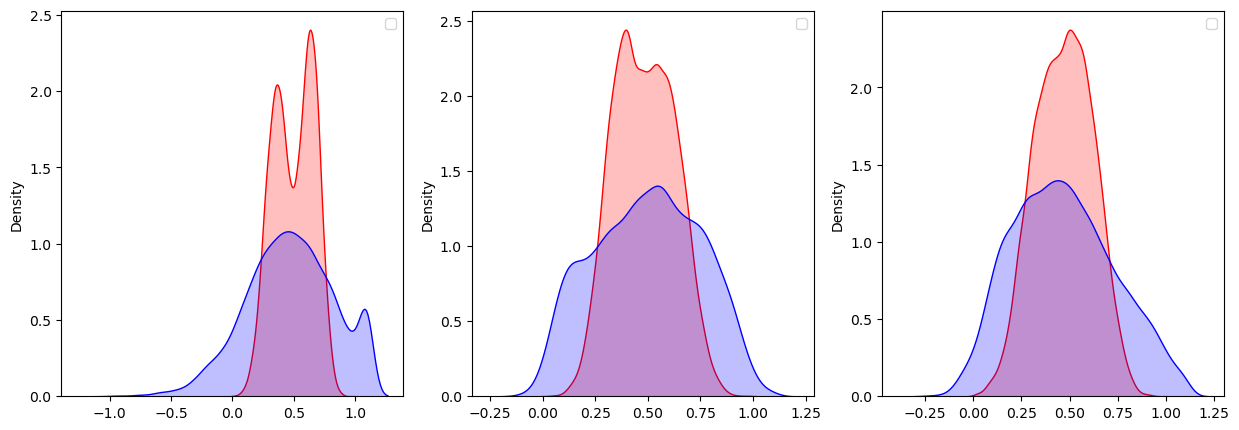

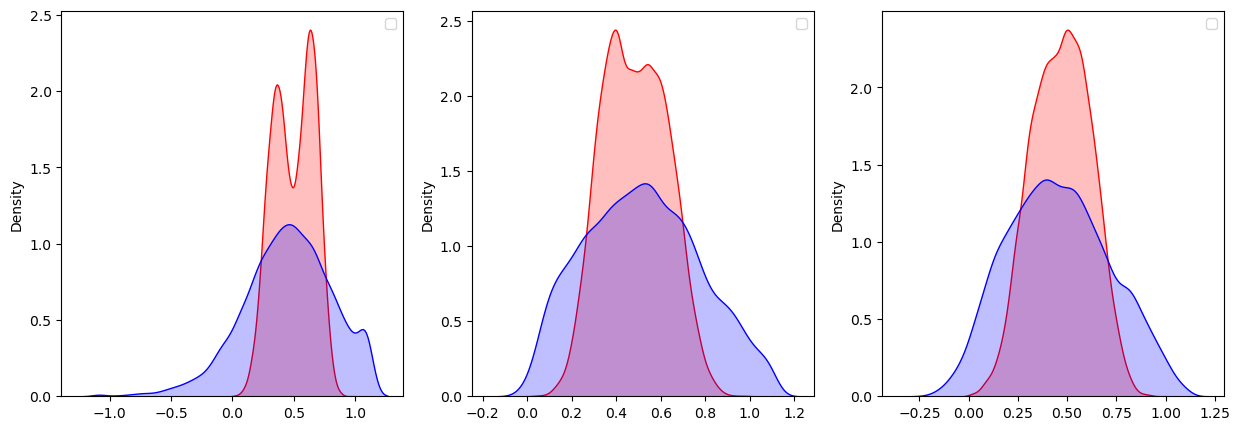

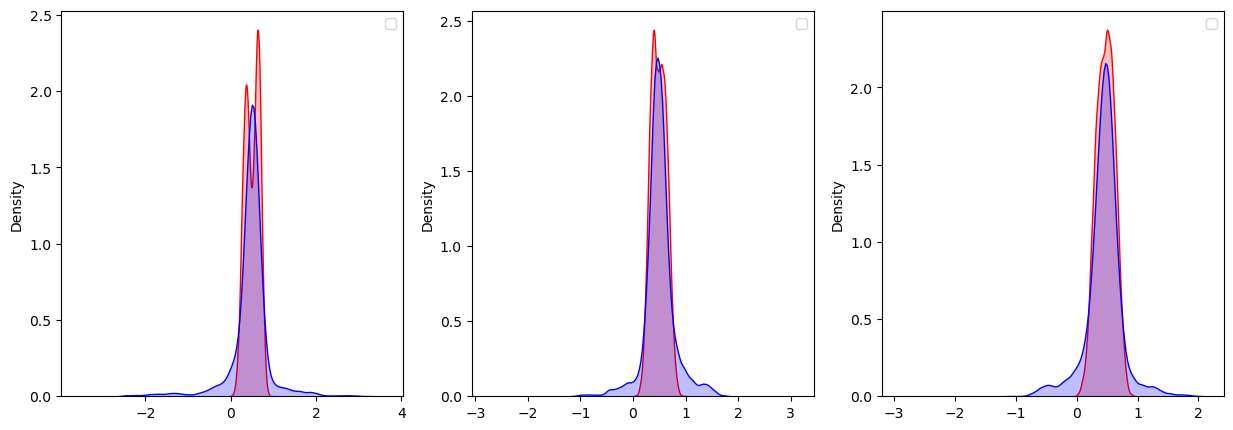

In [32]:
# Adding the density form the flow
# Give summary statistics of df_scaled
import seaborn as sns
samples_dpg = y#dgp(n_train)['df_scaled']
for i, name in enumerate(flows.keys()):
    flow = flows[name]
    samples_flow = flow().sample((10000,))
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Plotting the columns 1,2,3 of samples_flow against samples_dpg
    for i in range(3):
        sns.kdeplot(samples_dpg[:, i], ax=axs[i], fill=True, legend='DGP', color='red')
        sns.kdeplot(samples_flow[:, i], ax=axs[i], fill=True, legend='Flow', color='blue')
        #yy = flow().log_prob(xx[...,None]).exp().detach().numpy()
        #axs[i].plot(xx, yy, label=flow.__class__.__name__)
        axs[i].legend()
        #sns.title(name)
    fig.show()


In [31]:
import seaborn as sns

sns.kdeplot(samples[:,2], label="Samples")
sns.kdeplot(y_test[:,2], label="Test Data")
plt.xlabel("Third Dimension")
plt.ylabel("Density")
plt.title(f"Observational Data for flow {flow.__class__.__name__}")
plt.legend()
plt.show()

NameError: name 'samples' is not defined

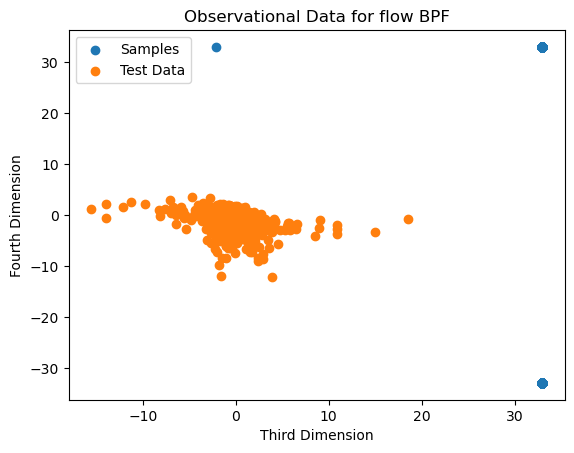

In [ ]:
### Plot the conturs of 3 and 4 dimensions
plt.figure()
plt.scatter(samples[:,2], samples[:,3], label="Samples")
plt.scatter(y_test[:,2], y_test[:,3], label="Test Data")
plt.xlabel("Third Dimension")
plt.ylabel("Fourth Dimension")
plt.title(f"Observational Data for flow {flow.__class__.__name__}")
plt.legend()
plt.show()


In [10]:
import numpy as np

def compare_quantiles(array1, array2, column_index):
    """
    Compares the quantiles of a specified column in array1 with array2.

    Parameters:
    array1 (numpy array): The first array to compare.
    array2 (numpy array): The second array to compare.
    column_index (int): The column index to compare from array1.

    Returns:
    tuple of numpy arrays: Quantiles of the specified column in array1 and array2.
    """
    # Extract the specified column from array1
    column_data = array1[:, column_index]

    # Ensure both column_data and array2 are one-dimensional
    column_data = column_data.flatten()
    array2 = array2.flatten()

    # Sort the data
    sorted_column_data = np.sort(column_data)
    sorted_array2 = np.sort(array2)

    # Check if lengths are different, and adjust if necessary
    min_length = min(len(sorted_column_data), len(sorted_array2))
    sorted_column_data = sorted_column_data[:min_length]
    sorted_array2 = sorted_array2[:min_length]

    # Generating quantiles
    quantiles = np.linspace(0, 1, min_length)

    # Calculating the quantiles for each sample
    quantiles_column_data = np.quantile(sorted_column_data, quantiles)
    quantiles_array2 = np.quantile(sorted_array2, quantiles)

    return quantiles_column_data, quantiles_array2


In [11]:
samples = flow(torch.ones([1000,1])).sample((1,))[0,:]
samples.shape

# QQ plot of the third dimension against the test data
quantiles_samples, quantiles_y_test = compare_quantiles(samples, y_test, 2)
# Plot the quantiles
plt.figure()
plt.scatter(quantiles_samples, quantiles_y_test)
plt.xlabel("Quantiles of Samples")
plt.ylabel("Quantiles of Test Data")
plt.title("QQ Plot of Third Dimension")
plt.show()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x5 and 4x150)